# 爬取國土測繪中心土地利用(LandUse)資料

## [國土測繪中心網站](http://whgis.nlsc.gov.tw/Flash/NLSC100_GIS.aspx)

並且整理存放至 MongoLab (網路雲端免費500mb的MongoDB資料庫)

---

### 環境：
Anaconda3 (Python 3.5)  
MongoDB (3.2.x) Database Name : nlsc-landuse

To connect using the mongo shell:
```
mongo ds163397.mlab.com:63397/nlsc-landuse -u <dbuser> -p <dbpassword>
```
To connect using a driver via the standard MongoDB URI (what's this?):
```
mongodb://<dbuser>:<dbpassword>@ds163397.mlab.com:63397/nlsc-landuse
```
dbuser: ShihChi


[Geopandas安裝疑難雜症](https://gist.github.com/gboeing/a6fcb39a9010d142446f4a83e43d8d6c)

In [1]:
#爬蟲用
import requests
#解析內文用
import json

#處理地理資訊工具包
import geopandas as gpd
#create Geometry object
from shapely.geometry import Point, Polygon
#轉座標
import fiona.crs

#繪圖
import matplotlib.pyplot as plt
#美化繪圖
import seaborn as sns

#執行緒
import threading, queue

#物件處理大師
import pandas as pd

%matplotlib inline

In [2]:
#取得土地利用資料
def getData(x, y, idlist):
    
    url  = 'http://whgis.nlsc.gov.tw/WS/MapDataProvider.asmx'
    headers = {'content-type': 'text/xml'}
    body = """<SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:s="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
      <SOAP-ENV:Body>
        <tns:SearchLandUseAttribute xmlns:tns="http://gis.fcu.com.tw/">
          <tns:pointX>{0}</tns:pointX>
          <tns:pointY>{1}</tns:pointY>
          <tns:buffer>16</tns:buffer>
        </tns:SearchLandUseAttribute>
      </SOAP-ENV:Body>
    </SOAP-ENV:Envelope>"""
    
    response = requests.post(url, data=body.format(x, y), headers=headers)
    data = response.text[311:-92].replace('\\r\\n','').replace(' ','')
    data = json.loads(data)
    
    for item in data:
        year = item['LandUseDataYear']
        ID = item['ObjectID']
        
        item['Geometry'] = json.loads(item['Geometry'])
        
        if not year in idlist:
            idlist['id'].append(ID)
            idlist[year] = [item]

        elif not ID in idlist['id']:
            idlist['id'].append(ID)
            idlist[year].append(item)

    
    #return data

In [3]:
#ploy class
def ploy2geo(idlist):
    
    print('start output')
    
    for year, item in idlist.items():
        
        if year == 'id':
            continue
        
        plist =[]
        
        for p in item:
            
            pout = gpd.GeoSeries(Polygon(p['Geometry'][0]))
            pin = [];
            
            for i in p['Geometry'][1:]:
                pp = Polygon(i)
                pin.append(pp)
            
            pin = gpd.GeoSeries(pin)
            pp = pout.difference(pin)
            
            g = gpd.GeoSeries(pp[0])
            gdf = gpd.GeoDataFrame({'geometry': g}, crs=fiona.crs.from_epsg(3826))
            
            for key, value in p.items():
                if (key != 'Geometry'):
                    gdf[key] = value
            
            plist.append(gdf)
            
        df = gpd.GeoDataFrame( pd.concat( plist, ignore_index=True), crs=fiona.crs.from_epsg(3826) )
        df.to_crs(epsg=4326, inplace=True)
        
        with open('geojson/{0}.geojson'.format(year), 'w') as f:
            f.write(df.to_json())


In [4]:
req_queue = queue.Queue()
idlist = {'id':[]}

def reqq(req_queue):
    while True:
        x, y, idlist = req_queue.get()
        
        #ploy2geo(getData(x, y, idlist))
        getData(x, y, idlist)
        
        req_queue.task_done()


#控制要開幾條執行緒
for n in range(100):
    req_thread = threading.Thread(target=reqq, args=(req_queue,))
    req_thread.daemon = True
    req_thread.start()


point = [227000, 2652000]
for i in range(30):
    for j in range(30):
        req_queue.put((point[0] + i * 100, point[1] + j * 100, idlist))


req_queue.join()

ploy2geo(idlist)

start output


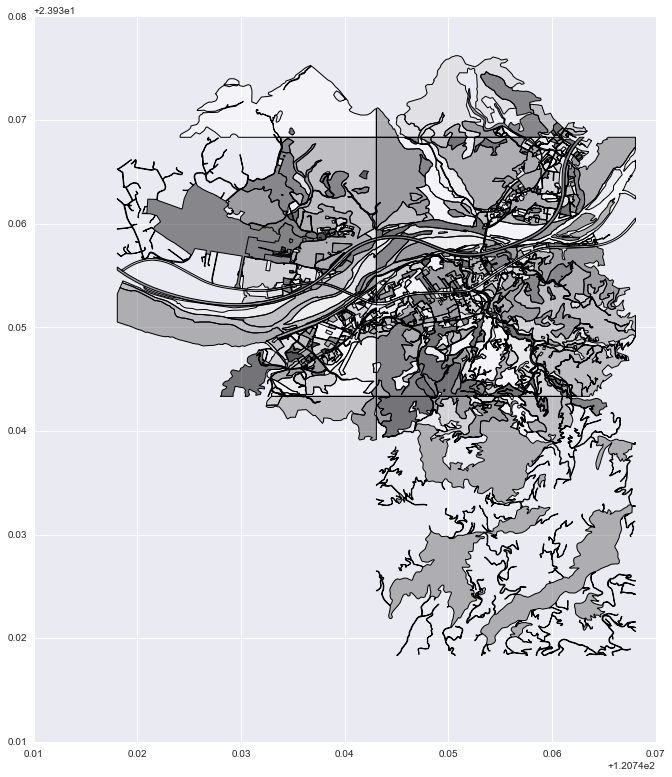

In [5]:
plt.rc('figure', figsize=(20, 13))

fname = "./geojson/LU103.geojson"
df = gpd.read_file(fname)

df.plot();

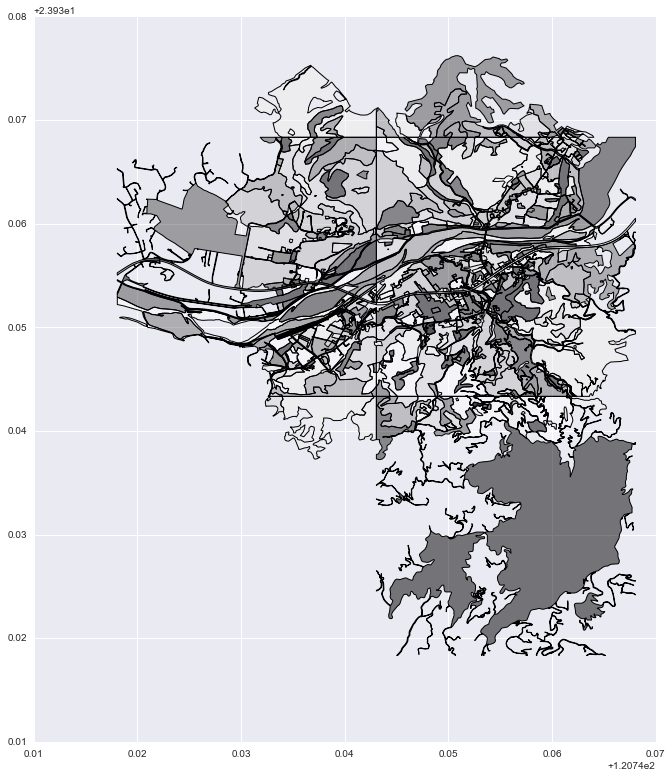

In [7]:
plt.rc('figure', figsize=(20, 13))

fname = "./geojson/LU095.geojson"
df = gpd.read_file(fname)

df.plot();

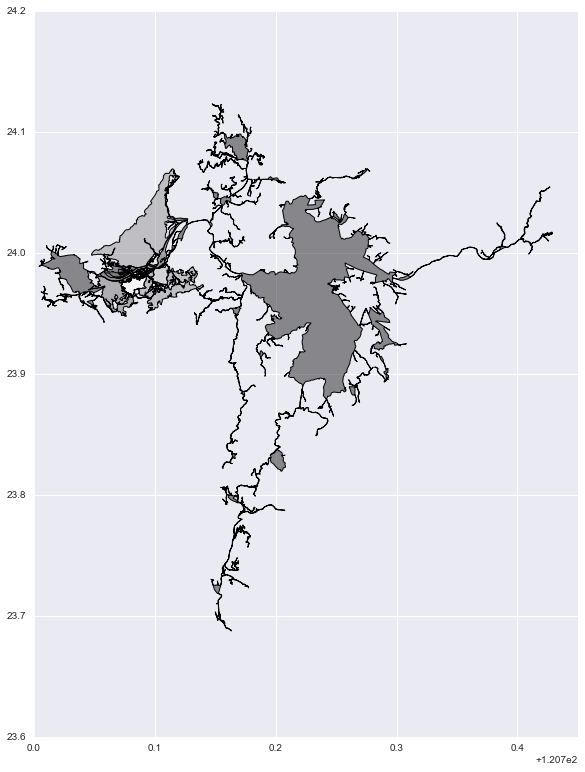

In [6]:
plt.rc('figure', figsize=(20, 13))

fname = "./geojson/LU082.geojson"
df = gpd.read_file(fname)

df.plot();